<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting "Greenness" Of Content


---


This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

### 1. Load the data
- Note it is a `.tsv` file and has a tab separator instead of comma.
- Clean the `is_news` column.
- Make two new columns, `title` and `body`, from the `boilerplate` column.

> **Note:** The `boilerplate` column is in json dictionary format. You can use the `json.loads()` function from the `json` module to convert this into a python dictionary.

In [2]:
evergreen_tsv = '../../assets/data/evergreen_sites.tsv'

In [3]:
data = pd.read_csv(evergreen_tsv, sep='\t', na_values={'is_news' : '?'}).fillna(0)

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

### 2. What are 'evergreen' sites?
- These are websites that always relevant like recipes or reviews (as opposed to current events).
- Stored as a binary indicator in the `label` column.
- Look at some examples.

In [4]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


### 3. Does being a news site affect green-ness?

**3.A Investigate with plots/EDA.**

            label
is_news          
0.0      0.507562
1.0      0.516916


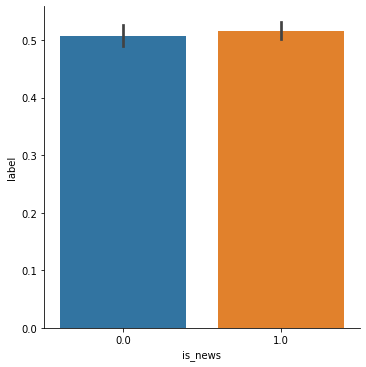

In [5]:
print((data.groupby('is_news')[['label']].mean()))
sns.factorplot(x='is_news', y='label', data=data, kind='bar')

**3.B Test the hypothesis with a logistic regression using statsmodels.**

> **Hint:** The `sm.logit` function from `statsmodels.formula.api` will perform a logistic regression using a formula string.

In [6]:
import statsmodels.formula.api as sm

In [7]:
news_data = data[['label','is_news']]

news_model = sm.logit("label ~ is_news", data=news_data).fit()
news_model.summary()

Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:               5.980e-05
Time:                        18:57:39   Log-Likelihood:                -5122.9
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                    0.4337
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0303      0.038      0.806      0.420      -0.043       0.104
is_news        0.0374      0.048      0.783      0.434      -0.056       0.131
==============================================================================
"""

**3.C Interpret the results of your model.**

In [8]:
# The effect of being a news site on evergreen status is insignificant.
# More formally, we would accept the null hypothesis that news sites and
# non-news sites have equal probability of being evergreen.

### 4. Does the website category affect green-ness?

**4.A Investigate with plots/EDA.**

In [9]:
# ? and unknown should be the same category:
data['alchemy_category'] = data.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

                       label
alchemy_category            
arts_entertainment  0.371945
business            0.711364
computer_internet   0.246622
culture_politics    0.457726
gaming              0.368421
health              0.573123
law_crime           0.419355
recreation          0.684296
religion            0.416667
science_technology  0.456747
sports              0.205263
unknown             0.501704
weather             0.000000


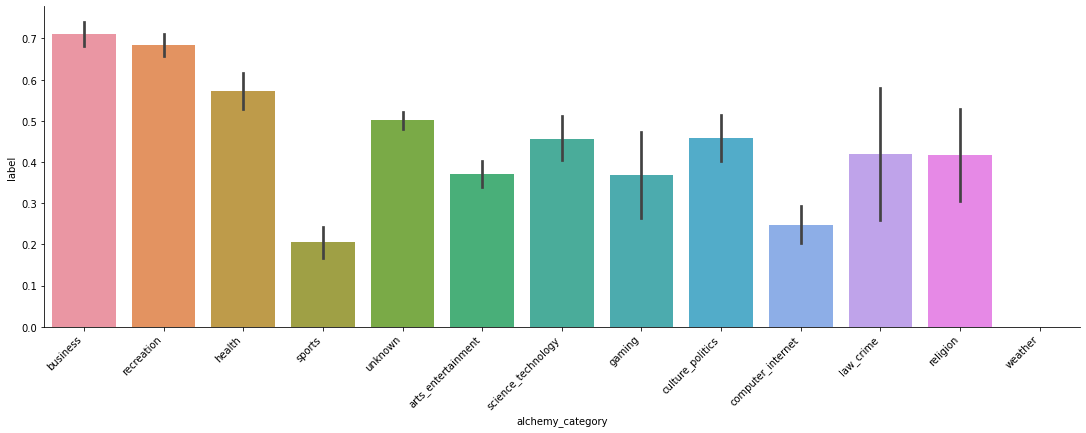

In [10]:
print((data.groupby('alchemy_category')[['label']].mean()))

sns.factorplot(x='alchemy_category', y='label', 
               data=data, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')


**4.B Test the hypothesis with a logistic regression.**

In [11]:
cat_model = sm.logit("label ~ C(alchemy_category, Treatment(reference='unknown'))", data=data).fit()
cat_model.summary()

         Current function value: 0.649499
         Iterations: 35


/Users/ohalloranb/opt/anaconda3/envs/bayes/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7382
Method:                           MLE   Df Model:                           12
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:                 0.06249
Time:                        18:57:40   Log-Likelihood:                -4803.0
converged:                      False   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                2.585e-129
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     0.0068      0.041      0.165      0.869      -0.074       0.088
C(alchemy_category, Treatment(reference='unknown'))[T.arts_entertainment]    -0.5307      0.079     -6.711      0.000      -0.686      -0.376
C(alchemy_category, Treatment(reference='unknown'))[T.business]               0.8952      0.085     10.522      0.000       0.728       1.062
C(alchemy_category, Treatment(reference='unknown'))[T.computer_internet]     -1.1235      0.141     -7.967      0.000      -1.400      -0.847
C(alchemy_category, Treatment(reference='unknown'))[T.culture_politics]      -0.1763      0.116     -1.520      0.128      -0.404       0.051
C(alchemy_category, Treatment(reference='unknown'))[T.gaming]                -0.5458      0.241     -2.261      0.024      -1.019      -0.073
C(alchemy_category, Treatment(reference='unknown'))[T.health]                 0.2878      0.099      2.910      0.004       0.094       0.482
C(alchemy_category, Treatment(reference='unknown'))[T.law_crime]             -0.3322      0.366     -0.907      0.364      -1.050       0.386
C(alchemy_category, Treatment(reference='unknown'))[T.recreation]             0.7668      0.074     10.367      0.000       0.622       0.912
C(alchemy_category, Treatment(reference='unknown'))[T.religion]              -0.3433      0.243     -1.415      0.157      -0.819       0.132
C(alchemy_category, Treatment(reference='unknown'))[T.science_technology]    -0.1803      0.125     -1.441      0.150      -0.425       0.065
C(alchemy_category, Treatment(reference='unknown'))[T.sports]                -1.3605      0.134    -10.188      0.000      -1.622      -1.099
C(alchemy_category, Treatment(reference='unknown'))[T.weather]              -18.1406   4331.829     -0.004      0.997   -8508.369    8472.087
=============================================================================================================================================
"""

**4.C Interpret the model results.**

In [12]:
# Many of the categories appear to have a significant effect on the likelihood of evergreen
# status. Note that I have set the reference category to be unknown. This is wrapped into
# the intercept term. These categories must be interpreted as significantly different from
# unknown or not.

# Positive predictors of evergreen vs. unknown:
# 1. Business
# 2. Health
# 3. Recreation

# Negative predictors of evergreen vs. unkown:
# 1. Arts and entertainment
# 2. Computer and internet
# 3. Gaming
# 4. Sports

# The rest of the categories are not significantly different than the unkown category
# in their probability of being evergreen or not.

### 5. Does the image ratio affect green-ness?

**5.A Investigate with plots/EDA.**

<AxesSubplot:xlabel='image_ratio'>

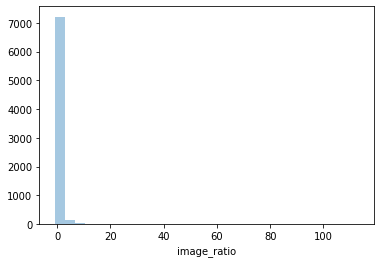

In [13]:
sns.distplot(data.image_ratio, bins=30, kde=False)

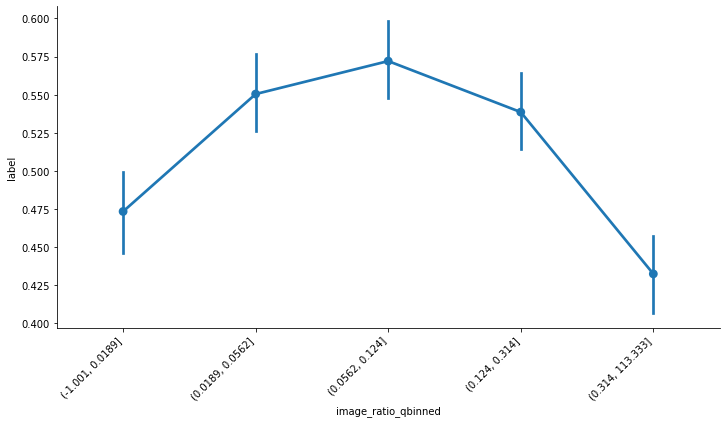

In [14]:
# qcut can divide things up by quantile - in this case into 5 bins
data['image_ratio_qbinned'] = pd.qcut(data['image_ratio'], 5)

sns.factorplot('image_ratio_qbinned', 'label', data=data, aspect=2).set_xticklabels(rotation=45, 
                                                                                  horizontalalignment='right')

**5.B Test the hypothesis using a logistic regression.**

> **Note**: It is worth thinking about how to best represent this variable. It may not be wise to input the image ratio as-is.

In [15]:
# a model using image ratio alone (ignoring the apparent nonlinear effect and skewed distribution):
image_model = sm.logit("label ~ image_ratio", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692631
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:               0.0002325
Time:                        18:57:40   Log-Likelihood:                -5122.0
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                    0.1228
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0590      0.024      2.499      0.012       0.013       0.105
image_ratio    -0.0210      0.015     -1.400      0.161      -0.051       0.008
===============================================================================
"""

In [16]:
# convert the image ratio to percentiles (this is what qcut is representing in bins):
# you can use the scipy.stats.percentileofscore for this:
from scipy import stats

data['image_ratio_pctl'] = data.image_ratio.map(lambda x: stats.percentileofscore(data.image_ratio.values, x))

<AxesSubplot:xlabel='image_ratio_pctl'>

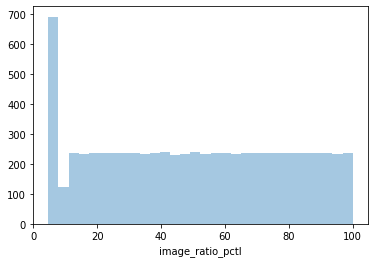

In [17]:
sns.distplot(data.image_ratio_pctl, bins=30, kde=False)

In [18]:
# use the image_ratio_percentile instead
# this is still ignoring the nonlinearity we wee in the plot above!
image_model = sm.logit("label ~ image_ratio_pctl", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:               0.0004832
Time:                        18:57:40   Log-Likelihood:                -5120.7
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                   0.02607
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1431      0.047      3.070      0.002       0.052       0.234
image_ratio_pctl    -0.0018      0.001     -2.224      0.026      -0.003      -0.000
====================================================================================
"""

In [19]:
# Fit a model with the percentile and the percentile squared (quadratic effect)
# This will let us model that inverse parabola
# Note: statsmodels formulas can take numpy functions!
image_model = sm.logit("label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2)", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.686094
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7392
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:                0.009668
Time:                        18:57:40   Log-Likelihood:                -5073.7
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                 3.084e-22
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3687      0.071     -5.219      0.000      -0.507      -0.230
image_ratio_pctl                  0.0289      0.003      8.808      0.000       0.022       0.035
np.power(image_ratio_pctl, 2)    -0.0003   3.18e-05     -9.644      0.000      -0.000      -0.000
=================================================================================================
"""

**5.C Interpret the model.**

In [20]:
# Once it's modeled well (convert the image ratio to percentiles and include
# a quadratic term) we can see these significant effects:

# 1. There is a positive effect of the image ratio percentile score (its rank 
# across image_ratios)

# 2. There is a negative quadratic effect of image ratio. That is to say, at
# a certain point the squared term of image_ratio_pctl overtakes the linear
# term. The highest probability of evergreen sites have image ratios in the
# median range.

### 6. Fit a logistic regression with multiple predictors.
- The choice of predictors is up to you. Test features you think may be valuable to predict evergreen status.
- Do any EDA you may need.
- Interpret the coefficients of the model.

> **Tip:** [This pdf is very useful for an overview of interpreting logistic regression coefficients.](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)

<AxesSubplot:xlabel='html_ratio'>

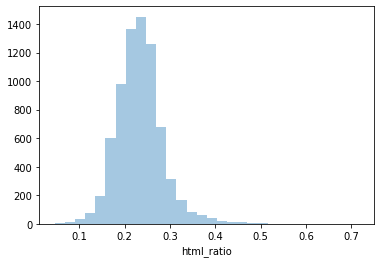

In [21]:
# look at the distribution of html_ratio
sns.distplot(data.html_ratio, bins=30, kde=False)

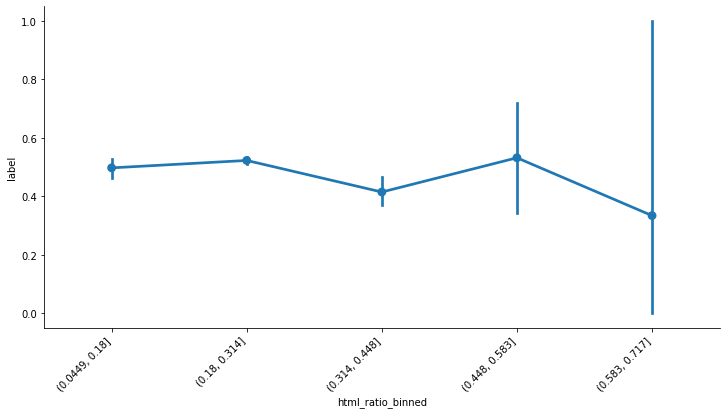

In [22]:
# cut can divide things up into linear bins - in this case into 5 bins
data['html_ratio_binned'] = pd.cut(data['html_ratio'], 5)
sns.factorplot('html_ratio_binned', 'label', data=data, aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right')

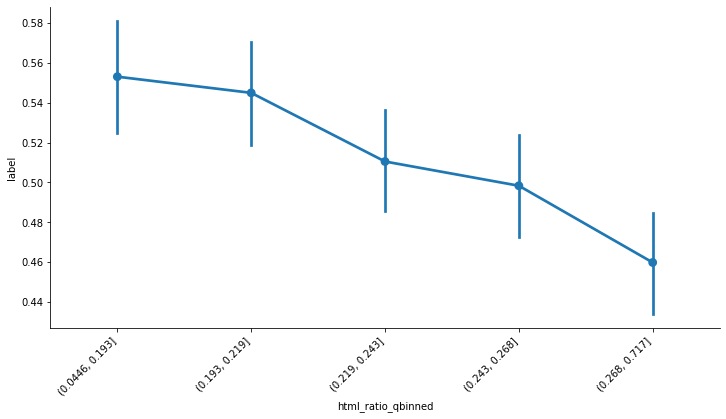

In [23]:
# cut can divide things up into linear bins - in this case into 5 bins
data['html_ratio_qbinned'] = pd.qcut(data['html_ratio'], 5)
sns.factorplot('html_ratio_qbinned', 'label', data=data, aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right')

In [24]:
data['html_ratio_pctl'] = data.html_ratio.map(lambda x: stats.percentileofscore(data.html_ratio.values, x))

In [25]:
# You can see scipy puts percentiles from 0-100: important for interpreting coefs
data.html_ratio_pctl.head()

0    63.029074
1    26.747803
2    46.085193
3    78.417850
4    48.275862
Name: html_ratio_pctl, dtype: float64

<AxesSubplot:xlabel='title_words'>

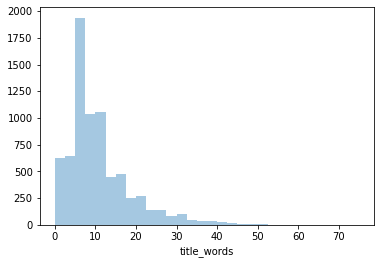

In [26]:
def title_len(x):
    try:
        return len(x.split())
    except:
        return 0.

# calculate the number of words in the title and plot distribution
data['title_words'] = data.title.map(title_len)
sns.distplot(data.title_words, bins=30, kde=False)

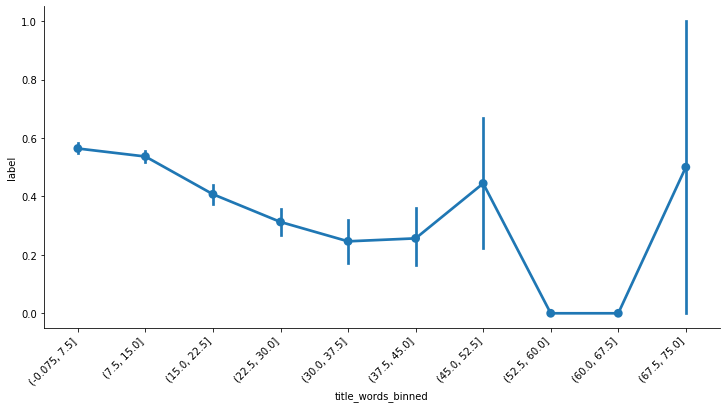

In [27]:
data['title_words_binned'] = pd.cut(data['title_words'], 10)

sns.factorplot('title_words_binned', 'label', data=data, aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right')

In [28]:
# Build a model with the image ratio percentile, html ratio, and title length
f = '''
label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2) + html_ratio_pctl + title_words
'''
model = sm.logit(f, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.667797
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7390
Method:                           MLE   Df Model:                            4
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:                 0.03608
Time:                        18:57:42   Log-Likelihood:                -4938.4
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                 9.885e-79
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.3855      0.096      4.015      0.000       0.197       0.574
image_ratio_pctl                  0.0382      0.003     11.181      0.000       0.031       0.045
np.power(image_ratio_pctl, 2)    -0.0004   3.31e-05    -12.514      0.000      -0.000      -0.000
html_ratio_pctl                  -0.0078      0.001     -8.438      0.000      -0.010      -0.006
title_words                      -0.0446      0.003    -13.928      0.000      -0.051      -0.038
=================================================================================================
"""

In [29]:
# exponentiate the coefficients to get the odds ratio:
np.exp(model.params)

Intercept                        1.470349
image_ratio_pctl                 1.038888
np.power(image_ratio_pctl, 2)    0.999585
html_ratio_pctl                  0.992222
title_words                      0.956410
dtype: float64

In [30]:
# We've got all significant effects on our predictors here.
# Must interpret them as odds ratios.
# 1. for a 1 percentile increase in image_ratio, there is a ~1.03x increase in the odds of evergreen
# 2. for a 1 unit increase in image_ratio_pctl**2, there is a ~0.999x decrease in the odds of evergreen
# 3. for a 1 percentile increase in html_ratio, there is a ~0.992x decrease in the odds of evergreen
# 4. for a 1 word increase in the length of the title, there is a ~0.956x decrease in the odds of evergreen